In [33]:
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import pandas as pd
from src.get_project_data import housing_data, locale_data

In [2]:
housing_df = housing_data()
locale_df = locale_data()

In [6]:
housing_df.head(10)

,date,zipcode,zip_name,pending_listing_count
0,2023-03-01,78044,NaN,<NA>
1,2023-03-01,79853,"tornillo, tx",<NA>
2,2023-03-01,78404,"corpus christi, tx",16
3,2023-03-01,77418,"bellville, tx",12
4,2023-03-01,77414,"bay city, tx",28
5,2023-03-01,77994,"westhoff, tx",<NA>
6,2023-03-01,79547,"rule, tx",1
7,2023-03-01,77363,"plantersville, tx",3
8,2023-03-01,76443,"cross plains, tx",3
9,2023-03-01,76481,"south bend, tx",<NA>


In [9]:
housing_df = housing_df[["date", "zipcode", "zip_name", "pending_listing_count"]]
print(housing_df.shape)
df_full = housing_df.merge(locale_df, how='left', on="zipcode")
# A blank is 0 for pending_listing_count
df_full["pending_listing_count"].fillna(0, inplace=True)
print(df_full.shape)
df_full.sample(10)

(134947, 4)
(134947, 5)


,date,zipcode,zip_name,pending_listing_count,LOCALE
108173,2017-10-01,75209,"dallas, tx",50,11
37209,2021-05-01,79556,"sweetwater, tx",15,42
28536,2021-10-01,77614,"deweyville, tx",0,42
6530,2022-12-01,76705,"waco, tx",16,41
42149,2021-02-01,78256,"san antonio, tx",18,11
132999,2016-08-01,77535,"dayton, tx",40,42
63875,2020-01-01,75491,"whitewright, tx",4,42
38318,2021-04-01,77076,"houston, tx",16,11
95293,2018-06-01,75039,"irving, tx",36,11
42427,2021-02-01,76273,"whitesboro, tx",14,42


In [11]:
by_month_totals = df_full.groupby("date")\
                         .agg({"pending_listing_count": "sum"})\
                         .rename(columns={"pending_listing_count": "Monthly Totals"})
by_month_totals.head()

,Monthly Totals
date,
2016-07-01,42224
2016-08-01,40987
2016-09-01,37550
2016-10-01,34867
2016-11-01,33618


In [17]:
df_grouped = df_full.groupby(["date", "LOCALE"])\
                    .agg({"pending_listing_count": "sum"})
df_grouped["Percent of Total"] = df_grouped["pending_listing_count"] / by_month_totals["Monthly Totals"] * 100
df_grouped.head(11)

pending_listing_count  Percent of Total
date       LOCALE                                         
2016-07-01 11                      11139         26.380731
           12                       1440          3.410383
           13                        210          0.497347
           21                      10467         24.789219
           22                        717          1.698086
           23                         14          0.033156
           31                        159          0.376563
           32                          6           0.01421
           41                      12823         30.368984
           42                       4862         11.514778
           43                        385          0.911804

In [55]:
# Plotting setup
plot_df = df_grouped.drop("pending_listing_count", axis=1)
land_color_list = ["#eb348c", "#fc4eda", "#e880ff",  # urban
                   "#ff9a26", "#fac852", "#fff759",  # suburban
                   "#1a2ca3", "#5477de", "#6cade6",  # town
                   "#85ed7b", "#59c24f", "#2e8f25",  # rural
                   ]
land_labels = ["Urban Large", "Urban Midsize", "Urban Small",
               "Suburban Large", "Suburban Midsize", "Suburban Small",
               "Town Fringe", "Town Distant", "Town Remote",
               "Rural Fringe", "Rural Distant", "Rural Remote",]

In [56]:
plot_df.unstack().head()

Percent of Total                                           \
LOCALE                   11        12        13         21        22   
date                                                                   
2016-07-01        26.380731  3.410383  0.497347  24.789219  1.698086   
2016-08-01        26.183912   3.26201  0.526996  24.944495  1.681021   
2016-09-01        26.516644  3.150466  0.460719  24.130493  1.664447   
2016-10-01        26.847736  3.186394  0.447414  24.765538  1.614707   
2016-11-01         27.04801  3.153073  0.464037  24.632637  1.606282   

                                                                                
LOCALE            23        31        32    33         41         42        43  
date                                                                            
2016-07-01  0.033156  0.376563   0.01421  <NA>  30.368984  11.514778  0.911804  
2016-08-01  0.026838  0.348891  0.017079  <NA>  30.165662  11.867177  0.973479  
2016-09-01  0.034621  0.351531  0.005326  <NA>  30.474035  12.231691  0.980027  
2016-10-01  0.034416  0.347033  0.005736  <NA>  29.862047  11.830671  1.049703  
2016-11-01  0.032721  0.288536  0.011898  <NA>  29.793563  11.868642  1.091677

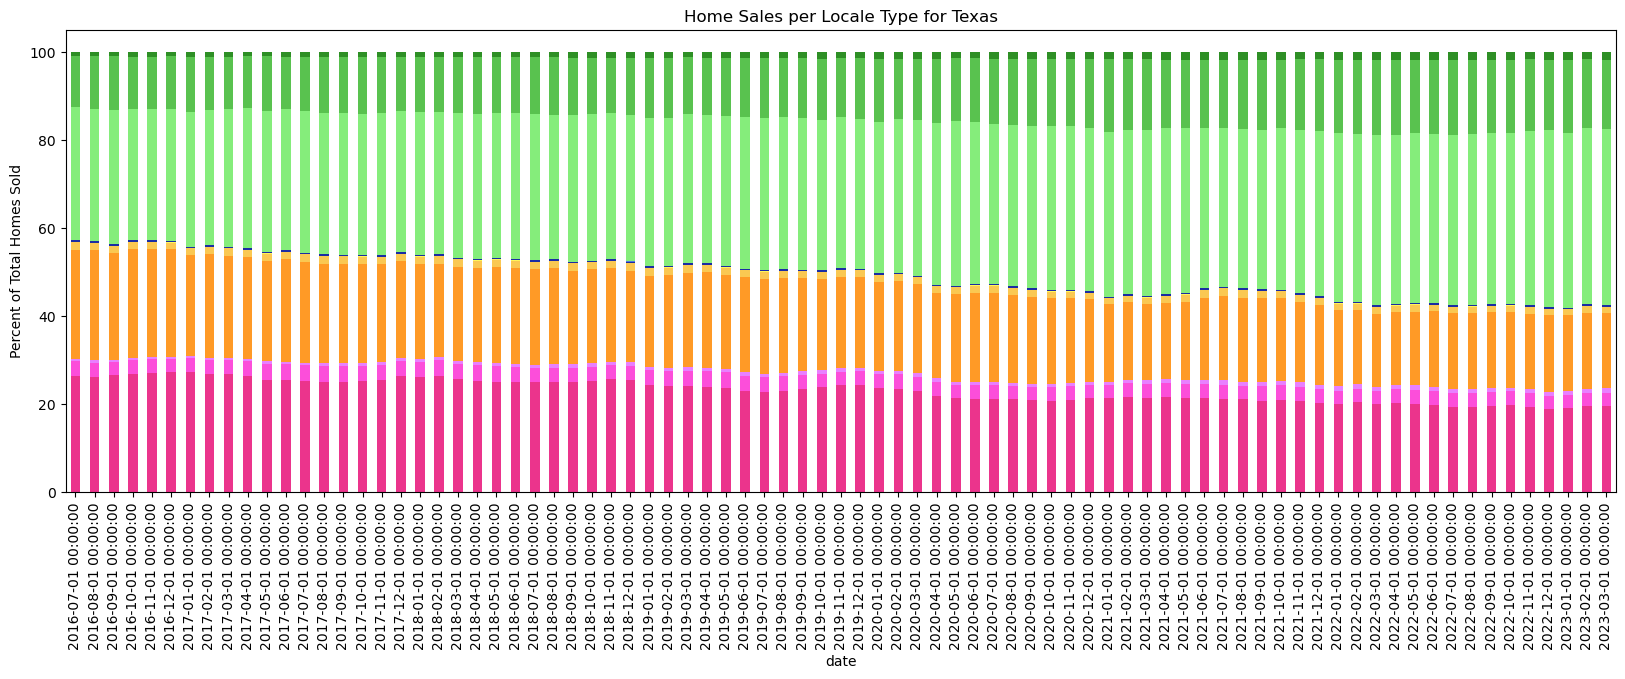

In [65]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_df.unstack().plot.bar(ax=ax, stacked=True, color=land_color_list, legend=False)
# ax.bar(x=plot_df.unstack().index, stacked=True)
ax.set(ylabel="Percent of Total Homes Sold", title="Home Sales per Locale Type for Texas")
# ax.xaxis.set_major_locator(YearLocator())
# ax.xaxis.set_major_formatter(DateFormatter("%Y"))
# ax.xaxis.set_major_locator(YearLocator(month=1))
# ax.xaxis.set_major_formatter(DateFormatter("%y-%m"))
# fig.autofmt_xdate()
plt.show()

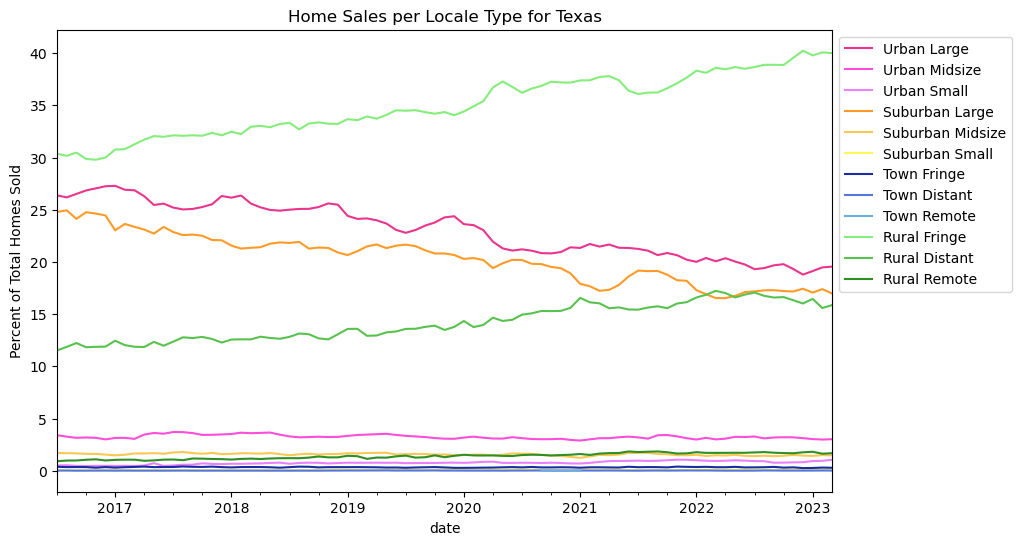

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_df.unstack().plot.line(ax=ax, y="Percent of Total", color=land_color_list)
ax.set(ylabel="Percent of Total Homes Sold", title="Home Sales per Locale Type for Texas")
ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
plt.show()